In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import datacompy
import os, sys
import numpy as np

# narzedzia
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    cross_val_predict,
    learning_curve,
    RepeatedStratifiedKFold,
    GridSearchCV,
)
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix, silhouette_score, accuracy_score
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from scipy import stats
from joblib import dump, load

# modele
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# methods
from imblearn.under_sampling import ClusterCentroids, NearMiss
from scipy.optimize import differential_evolution
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.inspection import permutation_importance

from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from ctgan import CTGAN

## Data

### Read data

In [2]:
#oversampling data
original_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\original_data.csv")    
original_data = original_data.drop(columns=["Unnamed: 0"])
smote_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\smote_data.csv")
GAN_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\GAN_data.csv")
borderline_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\borderline_data.csv")
smote2_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\smote3_data.csv")
GAN2_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\GAN3_data.csv")    
borderline2_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\borderline3_data.csv")

# test data
X_test = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\new\\test\\X_test.csv")
y_test = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\new\\test\\y_test.csv")

""" #undersampling prepare data //mixed data (gan, brdsmote, smote)
cc_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\clustercentroids_data.csv")
if_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\isolationforest_data.csv")
nm_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\nearmiss_data.csv")
median_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\median_data.csv")
lof_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\localoutlierfactor_data.csv") """


' #undersampling prepare data //mixed data (gan, brdsmote, smote)\ncc_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\clustercentroids_data.csv")\nif_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\isolationforest_data.csv")\nnm_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\nearmiss_data.csv")\nmedian_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\median_data.csv")\nlof_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\localoutlierfactor_data.csv") '

In [3]:
print(original_data["target"].value_counts())
count1=original_data["target"].value_counts().sum()
print(count1)
count2=abs((original_data['target']==0).sum() - (original_data['target']==1).sum())
print(f"Before undersampling: {count2}")
print(f"After number of samples: {count1+count2}")

target
0    151
1     46
Name: count, dtype: int64
197
Before undersampling: 105
After number of samples: 302


### Preprocessing Data

In [4]:
#mixed data
mix_data = pd.concat([GAN_data, smote_data, borderline_data, original_data], axis=0, ignore_index=True)         
mix_data = mix_data.reset_index(drop=True)

#data with one oversampling method and original data e.g.(smote+original)
smote_data = pd.concat([smote_data, smote2_data, original_data], axis=0, ignore_index=True)
smote_data = smote_data.reset_index(drop=True)
borderline_data = pd.concat([borderline_data, borderline2_data, original_data], axis=0, ignore_index=True)
borderline_data = borderline_data.reset_index(drop=True)
GAN_data = pd.concat([GAN_data, GAN2_data, original_data], axis=0, ignore_index=True)
GAN_data = GAN_data.reset_index(drop=True)

sum_all_data = pd.concat([smote_data, GAN_data, borderline_data, mix_data], axis=0, ignore_index=True)

#### Split data

In [5]:
X_mix, y_mix = mix_data.drop(columns=["target", "source"]), mix_data["target"]
X_smote, y_smote = smote_data.drop(columns=["target", "source"]), smote_data["target"]
X_GAN, y_GAN = GAN_data.drop(columns=["target", "source"]), GAN_data["target"]
X_borderline, y_borderline = borderline_data.drop(columns=["target", "source"]), borderline_data["target"]

#### Dictionary

In [6]:
data = {}
data["mix"] = (X_mix, y_mix)
data["smote"] = (X_smote, y_smote)
data["GAN"] = (X_GAN, y_GAN)
data["borderline"] = (X_borderline, y_borderline)

compare = {}
compare["mix"] = mix_data
compare["smote"] = smote_data
compare["GAN"] = GAN_data
compare["borderline"] = borderline_data

## Undersampling

### NearMiss version1

In [ ]:
NM = NearMiss(version=1)

for (name, (X_train, y_train)), (_, compare_df) in zip(data.items(), compare.items()):
    
    X_NM, y_NM = NM.fit_resample(X_train, y_train)
    
    #concat resampled data
    nearmiss_data = pd.concat([X_NM, y_NM], axis=1)
    
    NM_data_nosource = compare_df.drop(columns=["source"])
    nearmiss_data_nosource = nearmiss_data

    for index, row in nearmiss_data_nosource.iterrows():
        match = NM_data_nosource.eq(row).all(axis=1)  # Sprawdza, gdzie wiersze są identyczne
        if match.any():  # Jeśli znaleziono dopasowanie
            matched_index = match.idxmax()  # Pobiera pierwszy pasujący indeks
            nearmiss_data.loc[index, "source"] = compare_df.loc[matched_index, "source"]
            
    nearmiss_data.to_csv(f"D:\\ml\\undersampling_data\\data\\ssh\\reduced\\{name}_NM_data.csv")
    
    print(f"Data reduced for {name} data")
    print(nearmiss_data["target"].value_counts())
    

target
0    151
1    151
Name: count, dtype: int64
target
0    151
1    151
Name: count, dtype: int64
target
0    151
1    151
Name: count, dtype: int64
target
0    151
1    151
Name: count, dtype: int64


### K-means

In [15]:
KM = KMeans(n_clusters=(int)((count1+count2)/2))

for (name, (X_train, y_train)), (_, compare_df) in zip(data.items(), compare.items()):
    
    X_majority = X_train[y_train == 1]
    X_minority = X_train[y_train == 0]
    
    kmeans = KM.fit(X_majority)
    
    X_majority_reduced = pd.DataFrame(kmeans.cluster_centers_, columns=X_train.columns)
    y_majority_reduced = pd.Series([0] * (int)((count1+count2)/2), name="target")
    
    X_minority = X_minority.reset_index(drop=True)
    y_minority = pd.Series([1] * len(X_minority), name="target")
    
    X_final = pd.concat([X_majority_reduced, X_minority], axis=0).reset_index(drop=True)
    y_final = pd.concat([y_majority_reduced, y_minority], axis=0).reset_index(drop=True)
    
    # Concat resampled data
    reduced_data = pd.concat([X_final, y_final], axis=1)
    
    # Compare data to copy source column
    data_nosource = compare_df.drop(columns=["source"])
    reduced_data_nosource = reduced_data

    # Iterate through the rows in reduced_data_nosource
    for index, row in reduced_data_nosource.iterrows():
        match = data_nosource.eq(row).all(axis=1)  # Check where rows are identical
        if match.any():  # If a match is found
            matched_index = match.idxmax()  # Get the first matching index
            reduced_data.loc[index, "source"] = compare_df.loc[matched_index, "source"]
    
    reduced_data.to_csv(f"D:\\ml\\undersampling_data\\data\\ssh\\reduced\\{name}_KM_data.csv", index=False)
    
    print(f"Data reduced for {name} data")
    print(reduced_data["target"].value_counts())

c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Data reduced for mix data
target
0    151
1    151
Name: count, dtype: int64


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Data reduced for smote data
target
0    151
1    151
Name: count, dtype: int64


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Data reduced for GAN data
target
0    151
1    151
Name: count, dtype: int64


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Data reduced for borderline data
target
0    151
1    151
Name: count, dtype: int64


### AgglomerativeClustering

InvalidIndexError: (slice(None, None, None), 0)

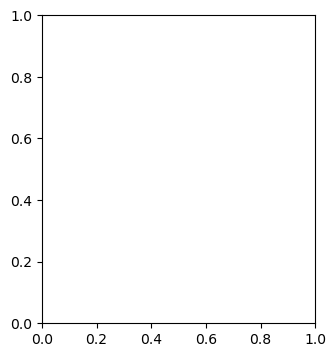

In [17]:
def plot_scatter(X, color, alpha=0.5):
    return plt.scatter(X[:, 0], X[:, 1], c=color, alpha=alpha, edgecolor="k")

AggC = AgglomerativeClustering(n_clusters=(int)((count1+count2)/2))

for (name, (X_train, y_train)), (_, compare_df) in zip(data.items(), compare.items()):
    
    X_CC= AggC.fit_predict(X_train)    
    
    plt.figure(figsize=(12, 4))

    plt.subplot(131)
    plot_scatter(X_train, X_CC)
    plt.title("Ward Linkage")
    
    # Concat resampled data
    reduced_data = pd.concat([X_CC, y_CC], axis=1)
    
    # Compare data to copy source column
    data_nosource = compare_df.drop(columns=["source"])
    reduced_data_nosource = reduced_data

    # Iterate through the rows in reduced_data_nosource
    for index, row in reduced_data_nosource.iterrows():
        match = data_nosource.eq(row).all(axis=1)  # Check where rows are identical
        if match.any():  # If a match is found
            matched_index = match.idxmax()  # Get the first matching index
            reduced_data.loc[index, "source"] = compare_df.loc[matched_index, "source"]
    
    reduced_data.to_csv(f"D:\\ml\\undersampling_data\\data\\ssh\\reduced\\{name}_CC_data.csv", index=False)
    
    print(f"Data reduced for {name} data")
    print(reduced_data["target"].value_counts())

### ClusterCentroids

In [18]:
CC = ClusterCentroids(sampling_strategy="majority", voting="auto")

for (name, (X_train, y_train)), (_, compare_df) in zip(data.items(), compare.items()):
    
    X_CC, y_CC = CC.fit_resample(X_train, y_train)
    
    # Concat resampled data
    reduced_data = pd.concat([X_CC, y_CC], axis=1)
    
    # Compare data to copy source column
    data_nosource = compare_df.drop(columns=["source"])
    reduced_data_nosource = reduced_data.drop(columns=["source"], errors='ignore')

    reduced_data["source"] = None  # Initialize the source column with None

    # Iterate through the rows in reduced_data_nosource
    for index, row in reduced_data_nosource.iterrows():
        match = data_nosource.eq(row).all(axis=1)  # Check where rows are identical
        if match.any():  # If a match is found
            matched_index = match.idxmax()  # Get the first matching index
            reduced_data.loc[index, "source"] = compare_df.loc[matched_index, "source"]
    
    # Check for any rows that still have None in the source column
    missing_source = reduced_data[reduced_data["source"].isna()]
    if not missing_source.empty:
        reduced_data.loc[reduced_data["source"].isna(), "source"] = "centroid"
    
    reduced_data.to_csv(f"D:\\ml\\undersampling_data\\data\\ssh\\reduced\\{name}_CC_data.csv", index=False)
    
    print(f"Data reduced for {name} data")
    print(reduced_data["target"].value_counts())

c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Data reduced for mix data
target
0    151
1    151
Name: count, dtype: int64


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Data reduced for smote data
target
0    151
1    151
Name: count, dtype: int64


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Data reduced for GAN data
target
0    151
1    151
Name: count, dtype: int64


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Data reduced for borderline data
target
0    151
1    151
Name: count, dtype: int64


In [47]:
comparison = datacompy.Compare(
        data_nosource,
        reduced_data_nosource,
        join_columns=data_nosource.columns.tolist(),  # List of columns to join on
        abs_tol=1e-5,  # Absolute tolerance for comparing numeric values
        rel_tol=1e-5,  # Relative tolerance for comparing numeric values
    )

In [48]:
print(comparison.report())

DataComPy Comparison
--------------------

DataFrame Summary
-----------------

  DataFrame  Columns  Rows
0       df1       13   919
1       df2       14   302

Column Summary
--------------

Number of columns in common: 13
Number of columns in df1 but not in df2: 0
Number of columns in df2 but not in df1: 1

Row Summary
-----------

Matched on: user, is_private, is_failure, is_root, is_valid, not_valid_count, ip_failure, ip_success, no_failure, first, td, ts, target
Any duplicates on match values: Yes
Absolute Tolerance: 1e-05
Relative Tolerance: 1e-05
Number of rows in common: 223
Number of rows in df1 but not in df2: 696
Number of rows in df2 but not in df1: 79

Number of rows with some compared columns unequal: 0
Number of rows with all compared columns equal: 223

Column Comparison
-----------------

Number of columns compared with some values unequal: 0
Number of columns compared with all values equal: 13
Total number of values which compare unequal: 0

Sample Rows Only in df1 (

In [34]:
print(reduced_data.columns.to_list())
print(borderline_data.columns.to_list())

['user', 'is_private', 'is_failure', 'is_root', 'is_valid', 'not_valid_count', 'ip_failure', 'ip_success', 'no_failure', 'first', 'td', 'ts', 'target', 'source']
['user', 'is_private', 'is_failure', 'is_root', 'is_valid', 'not_valid_count', 'ip_failure', 'ip_success', 'no_failure', 'first', 'td', 'ts', 'target', 'source']
